## **MileStone_3**

1.   Build a deep learning model for the dataset
2. Investigate effects of mini-batch learning
3. Investigate effects of different optimizers.
4. Tune hyperparameters (training testing and validation).  
5. Explain conclusions about hyperparameters in colab markdown cells.



## **Import Packages & Functions**
The "getfile" function splits the loaded dataset into debuggin_dataset & working_dataset by a certain year.

In [ ]:
import pandas
import numpy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

def getfile(location_pair,**kwargs):
    (loc,gdrive)=location_pair
    loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]

    #Convert these datasets to pandas
    raw_dataset=pandas.read_csv(loc,**kwargs)
    #Convert datetime to pandas timestamps
    raw_dataset['DATE'] = pandas.to_datetime(raw_dataset['DATE'], format='%Y / %m')

    ## seperate the data by "year"
    split_date = '2005-01-01'
    debugging_dataset = raw_dataset[raw_dataset['DATE'] < split_date] #1990-2005
    debugging_dataset = debugging_dataset.sort_values(by='DATE', ascending=True)
    debugging_dataset = debugging_dataset.reset_index(drop=True) # reset the data index

    working_dataset = raw_dataset[raw_dataset['DATE'] >= split_date] #2005-2023
    working_dataset = working_dataset.sort_values(by='DATE', ascending=True)
    working_dataset = working_dataset.reset_index(drop=True) # reset the data index

    return raw_dataset, debugging_dataset, working_dataset

### Rename the features
column_name_mapping = {
    'POPULATION': 'Population',
    'POPULATION PERCENTAGE': 'Population Percentage',
    'AWND': 'Avg. Wind Speed',
    'PRCP': 'Rainfall',
    'SNOW': 'Snowfall',
    'TAVG': 'Avg. Temp',
    'TMAX': 'Max Temp',
    'TMIN': 'Min Temp',
    'TSUN': 'Sun Time',
    'REFUSETONSCOLLECTED': 'Refuse Tonnage',
    'PAPERTONSCOLLECTED': 'Paper Tonnage',
    'MGPTONSCOLLECTED': 'Metal, Glass, and Plastic Tonnage',
    'RESORGANICSTONS': 'Residential Organics Tonnage',
    'SCHOOLORGANICTONS': 'School Organic Tonnage',
    'LEAVESORGANICTONS': 'Leaves Organic Tonnage',
    'XMASTREETONS': 'Christmas tree Tonnage',
    'Bronx': 'Borough (Bronx)',
    'Brooklyn': 'Borough (Brooklyn)',
    'Manhattan': 'Borough (Manhattan)',
    'Queens': 'Borough (Queens)',
    'Staten Island': 'Borough (Staten Island)'
}

# **Load the dataset from CSV files**
There are two datasets we download from open-sources: New York population_weather data & New York tonnage data.
We merged these two datasets before generating the debugging and working datasets.  


In [ ]:
# **Import the CSV files**
fname_1=("NY_Population_Weather_Data.csv","https://drive.google.com/file/d/1DkB88nrVF2B60Rjxi_7fzRnD31-LUqXH/view?usp=sharing") #Load the New York population&weather dataset.
fname_2=("NY_Tonnage_Data_v2.csv","https://drive.google.com/file/d/1-57Sr-WC3g5MRxSXCun6HpD-SB1C-B6Q/view?usp=sharing") #Load the New York tonnage dataset.

raw_dataset_1, debugging_dataset_1, working_dataset_1=getfile(fname_1)
raw_dataset_2, debugging_dataset_2, working_dataset_2=getfile(fname_2)
print("NY_Population_Weather_Data_dataset dimension:", raw_dataset_1.shape)
print("NY_Tonnage_Data_dataset dimension:", raw_dataset_2.shape)

### **Merge the working_dataset:**
working_dataset = pandas.merge(working_dataset_1, working_dataset_2, on=["DATE", "BOROUGH"], how='right')
working_dataset.to_pickle('./working_dataset.pkl')#Pickle the data
#print(debugging_dataset.head())

### **Merge the debug_dataset:**
debugging_dataset = pandas.merge(debugging_dataset_1, debugging_dataset_2, on=["DATE", "BOROUGH"], how='right')
debugging_dataset.to_pickle('./debugging_dataset.pkl')#Pickle the data

### **Choose the dataset here:**
#dataset = debugging_dataset
dataset = working_dataset
dataset.head()

NY_Population_Weather_Data_dataset dimension: (2023, 11)
NY_Tonnage_Data_dataset dimension: (1983, 9)


,DATE,BOROUGH,POPULATION,POPULATION PERCENTAGE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,TSUN,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS
0,2005-01-01,Bronx,1332650,16.64,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,34286.3,2608.2,2470.4,0.0,0.0,0.0,102.5
1,2005-01-01,Brooklyn,2465326,30.78,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,64813.8,7625.3,5271.2,0.0,0.0,0.0,318.2
2,2005-01-01,Manhattan,1537195,19.20,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,40923.0,7255.1,3664.3,0.0,0.0,0.0,312.3
3,2005-01-01,Queens,2229379,27.84,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,54397.7,8353.7,5305.8,0.0,0.0,0.0,399.1
4,2005-01-01,Staten Island,443728,5.54,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,13882.9,2815.9,1444.3,0.0,0.0,0.0,244.1


## **Data pre-process on the debugging dataset(one-hot, imputer, and scaler)**
Because the type of Borough data was stored in 'String' instead of numerical values, we applied one-hot to split the data into multiple columns.
The Data data was split into "year" and "month" for representing.

In [ ]:
#Apply One-Hot to separate the BOROUGH types & DATE in columns
dataset = pandas.get_dummies(dataset, columns=['BOROUGH'], prefix=[None]) #one-hot on BOROUGH
dataset['DATE'] = pandas.to_datetime(dataset['DATE']) # separate the date into two columns, "year" & "month"
dataset['Year'] = dataset['DATE'].dt.year #add new column "year"
dataset['Month'] = dataset['DATE'].dt.month #add new column "month"
dataset = dataset.drop(columns=['DATE']) #drop the "DATE" columns

### ***Change the name of the waste tonnage dataset
dataset.rename(columns=column_name_mapping, inplace=True)
dataset.head()

,Population,Population Percentage,Avg. Wind Speed,Rainfall,Snowfall,Avg. Temp,Max Temp,Min Temp,Sun Time,Refuse Tonnage,...,School Organic Tonnage,Leaves Organic Tonnage,Christmas tree Tonnage,Borough (Bronx),Borough (Brooklyn),Borough (Manhattan),Borough (Queens),Borough (Staten Island),Year,Month
0,1332650,16.64,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,34286.3,...,0.0,0.0,102.5,1,0,0,0,0,2005,1
1,2465326,30.78,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,64813.8,...,0.0,0.0,318.2,0,1,0,0,0,2005,1
2,1537195,19.20,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,40923.0,...,0.0,0.0,312.3,0,0,1,0,0,2005,1
3,2229379,27.84,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,54397.7,...,0.0,0.0,399.1,0,0,0,1,0,2005,1
4,443728,5.54,3.3,118.7,389.0,-0.38,3.01,-3.78,NaN,13882.9,...,0.0,0.0,244.1,0,0,0,0,1,2005,1


### **Generate the input features and targeting label for training**
X is the feed-in feature (16 features)

Y is the targeting label (7 types of trash)

In [ ]:
### **Replace the 'nan' values & normalize the values**
imputer_zero = SimpleImputer(missing_values=numpy.nan, strategy='constant', fill_value=0) #replace the 'nan' value to be 0
imputer_mean = SimpleImputer(missing_values=numpy.nan, strategy='mean') #replace the 'nan' value to be mean
scaler_X = StandardScaler() #standard normalization
columns_of_feature = ['Population','Population Percentage','Avg. Wind Speed','Rainfall','Snowfall','Avg. Temp','Max Temp','Min Temp','Sun Time','Year','Month']
columns_of_target = ['Refuse Tonnage', 'Paper Tonnage', 'Metal, Glass, and Plastic Tonnage', 'Residential Organics Tonnage', 'School Organic Tonnage', 'Leaves Organic Tonnage', 'Christmas tree Tonnage']
columns_for_imputer = ['Avg. Wind Speed','Rainfall','Snowfall','Avg. Temp','Max Temp','Min Temp','Sun Time']

### **Generate the input features (X)**
X = dataset.drop(columns=columns_of_target) #only remain the input features we need
X[columns_for_imputer] = imputer_zero.fit_transform(X[columns_for_imputer])  #replace the 'nan' value to be 0
X[['Population','Population Percentage']] = imputer_mean.fit_transform(X[['Population','Population Percentage']])  #replace the 'nan' value to be mean
X[columns_of_feature] = scaler_X.fit_transform(X[columns_of_feature]) #standard scale

print('Features shape:',X.shape)
print('-----------------------------------------------------------------------------------')
X.head()

Features shape: (1125, 16)
-----------------------------------------------------------------------------------


,Population,Population Percentage,Avg. Wind Speed,Rainfall,Snowfall,Avg. Temp,Max Temp,Min Temp,Sun Time,Borough (Bronx),Borough (Brooklyn),Borough (Manhattan),Borough (Queens),Borough (Staten Island),Year,Month
0,-0.432330,-0.379753,1.188141,0.135195,2.079729,-1.581854,-1.583219,-1.573669,0.0,1,0,0,0,0,-1.640354,-1.584111
1,1.118744,1.218375,1.188141,0.135195,2.079729,-1.581854,-1.583219,-1.573669,0.0,0,1,0,0,0,-1.640354,-1.584111
2,-0.152229,-0.090417,1.188141,0.135195,2.079729,-1.581854,-1.583219,-1.573669,0.0,0,0,1,0,0,-1.640354,-1.584111
3,0.795641,0.886091,1.188141,0.135195,2.079729,-1.581854,-1.583219,-1.573669,0.0,0,0,0,1,0,-1.640354,-1.584111
4,-1.649611,-1.634295,1.188141,0.135195,2.079729,-1.581854,-1.583219,-1.573669,0.0,0,0,0,0,1,-1.640354,-1.584111


In [ ]:
### **Generate the targeting data (Y)**
scaler_Y = StandardScaler() #standard normalization
Y = dataset[columns_of_target] #Amount of Tonnage (per type of trash)
Y =  pandas.DataFrame(scaler_Y.fit_transform(Y),columns=Y.columns) #standard scale
#warnings.filterwarnings("ignore")
print('Target shape:',Y.shape)
print('-----------------------------------------------------------------------------------')
Y.head()

Target shape: (1125, 7)
-----------------------------------------------------------------------------------


,Refuse Tonnage,Paper Tonnage,"Metal, Glass, and Plastic Tonnage",Residential Organics Tonnage,School Organic Tonnage,Leaves Organic Tonnage,Christmas tree Tonnage
0,-0.450451,-1.056936,-0.927125,-0.431049,-0.544265,-0.1323,0.833855
1,1.116152,1.059151,0.501355,-0.431049,-0.544265,-0.1323,3.141352
2,-0.109871,0.903010,-0.318205,-0.431049,-0.544265,-0.1323,3.078235
3,0.581621,1.366372,0.519002,-0.431049,-0.544265,-0.1323,4.006797
4,-1.497509,-0.969333,-1.450463,-0.431049,-0.544265,-0.1323,2.348651


In [ ]:
### Split the dataset into training/validation/testing set by a ratio 8:1:1
X_train,X_temp,Y_train,Y_temp=train_test_split(X,Y,test_size=0.2,shuffle=False,random_state=42)
X_val,X_test,Y_val,Y_test=train_test_split(X_temp,Y_temp,test_size=0.5,shuffle=False,random_state=42) #0.27

#convert the dataset into tensor type for feeding the Pytorch model
X_tf = torch.tensor(X_train.values, dtype=torch.float32)
Y_tf = torch.tensor(Y_train.values, dtype=torch.float32)
X_test_tf = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tf = torch.tensor(Y_test.values, dtype=torch.float32)
X_val_tf = torch.tensor(X_val.values, dtype=torch.float32)
Y_val_tf = torch.tensor(Y_val.values, dtype=torch.float32)

print('# of training dataset', len(X_tf))
print('# of validation dataset', len(X_val_tf))
print('# of testing dataset', len(X_test_tf))

# of training dataset 900
# of validation dataset 112
# of testing dataset 113


# **Tune hyperparameters (training testing and validation)**
Set a tunable hidden layer linear regression model

In [ ]:
class RegressionModel_tunning(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=7, SEED=0):
        super(RegressionModel_tunning, self).__init__()
        if SEED is not None:
            torch.manual_seed(SEED)
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size)) #simple linear layers
            layers.append(nn.ReLU()) #apply ReLU as an acitivation layer for each hidden layers
            input_size = hidden_size #ensure the dimension between layers

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

## **Hyperparameters setup/tunning**

In [ ]:
hidden_dim = [[128, 64, 64, 32],[128, 64, 32, 16],[64,32,32,16],[64,32,16,8]]

for dim in hidden_dim:
  print('----------------------------------------------------------------------------------------------')
  print('The hidden layer dimension is:', dim)
  model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=dim) #assign the dimension of output layer = 7
  Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and a constant learning rate = 0.01 for training
  scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1) #then decrease
  best_val_loss = float('inf')
  MAX_iter = 1000 +1

  #print(model)
  print('----------------------------------------------------------------------------------------------')
  for itr in range(MAX_iter):
      optimizer.zero_grad() #start with zero gradient
      outputs = model(X_tf) #input the tensors into model to get the outputs
      target = Y_tf #assign the comparable target data (ground truth)
      lossvalue = Loss(outputs, target)  #compute the loss
      lossvalue.backward()
      optimizer.step()

      ### Validation
      model.eval()
      with torch.no_grad():
          val_outputs = model(X_val_tf)
          val_loss = Loss(val_outputs, Y_val_tf)

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        scheduler.step()

      if itr %200 == 0:
          print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

----------------------------------------------------------------------------------------------
The hidden layer dimension is: [128, 64, 64, 32]
----------------------------------------------------------------------------------------------
iteration 0: training loss=0.93337, validation loss=1.06527, learning rate=0.1000000000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


KeyboardInterrupt: ignored

# **Train the model with tunned hyperparameters**
According to the hyperparameters tunning process, the dimension of the hidden layer performs better with [256, 128, 64, 32].

In [97]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.SGD(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 1000 +1

print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    best_model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_last_lr()[0]))

### **Test the trained model**
Loss = nn.L1Loss()
with torch.no_grad():
    outputs1= best_model(X_test_tf) #input the tensors into model to get the outputs
    test_loss = Loss(outputs1, Y_test_tf) #compute the loss with ground truth(Y)
print(f"Test Loss: {test_loss.item()}")

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=0.95354, validation loss=0.91524, learning rate=0.1000000000
iteration 500: training loss=0.42909, validation loss=0.58273, learning rate=0.0250000000
iteration 1000: training loss=0.36182, validation loss=1.03863, learning rate=0.0250000000
Test Loss: 0.6815232038497925


Explain conclusions about hyperparameters in colab markdown cells:

We explored 4 different hyperparameters in this model, batch size, number of epochs, number of layers, and layer sizes. For epochs, we found that less epochs significantly improved training run time, which was important as it would allow us to test more iterations of the other hyperparameters.We chose the minimun epoch number that would result in acceptable performance and loss comparable to the number of epochs that would give us the best accuracy. For batch size, this was tested manually using various mini-batch sizes, in comparison to a whole batch. We found that using mini-batches improved performance by approximately 30%. We also explored hidden layer dimentions and number of layers, by creating a variety of iterations that could possibly give good results, based on past experience. We iterated through these, and found that 4 hidden layers, with sizes [256, 128, 64, 32] would give us the best accuracy and minimal loss.




# **Investigate effects of different optimizers**



```
1. Adadelta
```



RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1.16386, learning rate=0.1000000000
iteration 500: training loss=0.50273, validation loss=0.65162, learning rate=0.0590490000
iteration 1000: training loss=0.44207, validation loss=0.61557, learning rate=0.0348678440
iteration 1500: training loss=0.41255, validation loss=0.60068, learning rate=0.0205891132
iteration 2000: training loss=0.39497, validation loss=0.58880, learning rate=0.0121576655
iteration 2500: training loss=0.3

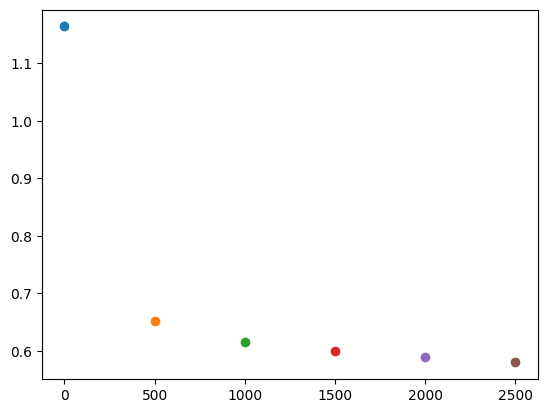

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.Adadelta(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

2. Adagrad

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1974.11670, learning rate=0.1000000000
iteration 500: training loss=0.57272, validation loss=0.73124, learning rate=0.0810000000
iteration 1000: training loss=0.49903, validation loss=0.71513, learning rate=0.0729000000
iteration 1500: training loss=0.47675, validation loss=0.69090, learning rate=0.0729000000
iteration 2000: training loss=0.41746, validation loss=0.64677, learning rate=0.0656100000
iteration 2500: training loss=

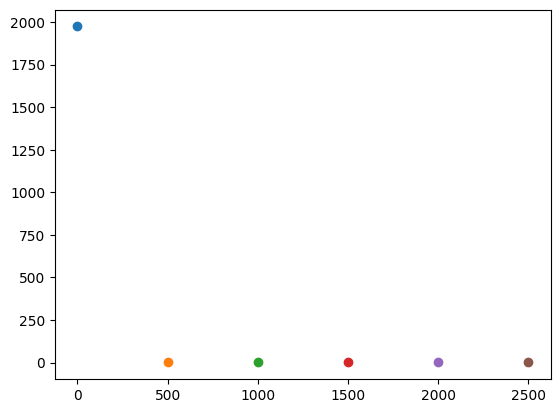

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.Adagrad(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

3. Adam

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1955.93628, learning rate=0.1000000000
iteration 500: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 1000: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 1500: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 2000: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 2500: training loss=

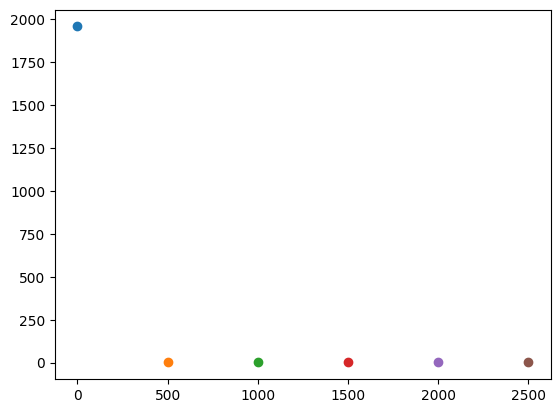

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

4. AdamW

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1951.90601, learning rate=0.1000000000
iteration 500: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 1000: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 1500: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 2000: training loss=0.99133, validation loss=1.15152, learning rate=0.1000000000
iteration 2500: training loss=

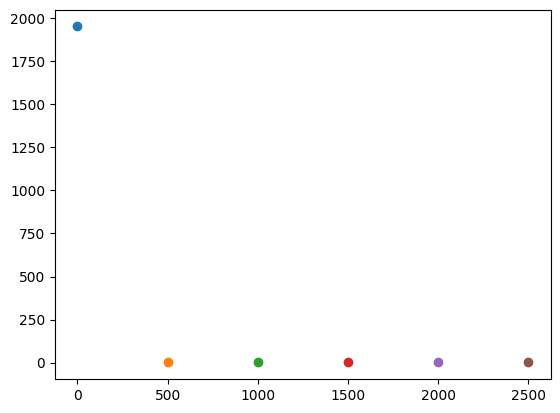

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.AdamW(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

5. Adamax

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1955.93750, learning rate=0.1000000000
iteration 500: training loss=0.99470, validation loss=1.15153, learning rate=0.0900000000
iteration 1000: training loss=0.99145, validation loss=1.15094, learning rate=0.0729000000
iteration 1500: training loss=0.99133, validation loss=1.15147, learning rate=0.0729000000
iteration 2000: training loss=0.99133, validation loss=1.15152, learning rate=0.0729000000
iteration 2500: training loss=

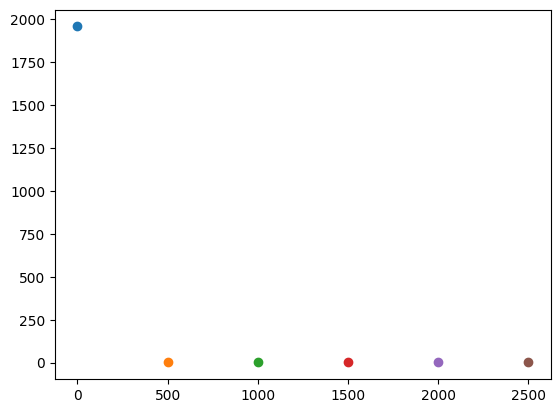

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.Adamax(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

6. ASGD

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1.16276, learning rate=0.1000000000
iteration 500: training loss=0.49380, validation loss=0.64583, learning rate=0.0590490000
iteration 1000: training loss=0.43668, validation loss=0.61488, learning rate=0.0313810596
iteration 1500: training loss=0.40577, validation loss=0.59765, learning rate=0.0185302019
iteration 2000: training loss=0.38788, validation loss=0.58426, learning rate=0.0135085172
iteration 2500: training loss=0.3

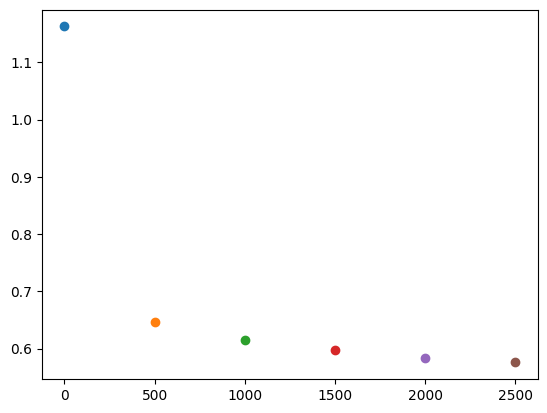

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.ASGD(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

7. NAdam

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=3021.74927, learning rate=0.1000000000
iteration 500: training loss=0.71738, validation loss=0.86686, learning rate=0.0900000000
iteration 1000: training loss=0.69164, validation loss=0.86587, learning rate=0.0900000000
iteration 1500: training loss=0.67758, validation loss=0.86804, learning rate=0.0900000000
iteration 2000: training loss=0.67283, validation loss=0.85980, learning rate=0.0900000000
iteration 2500: training loss=

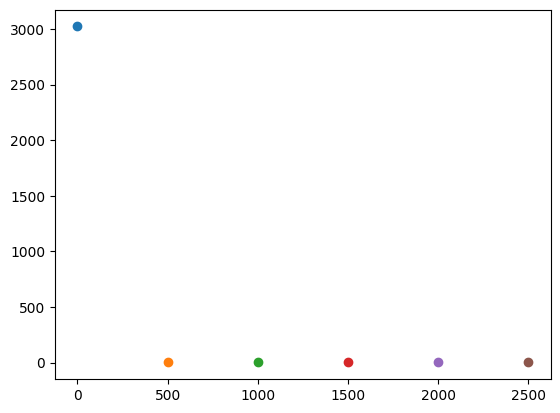

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.NAdam(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

8. RAdam

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1.16276, learning rate=0.1000000000
iteration 500: training loss=0.01351, validation loss=0.44929, learning rate=0.1000000000
iteration 1000: training loss=0.01654, validation loss=0.38994, learning rate=0.1000000000
iteration 1500: training loss=0.06843, validation loss=0.52776, learning rate=0.1000000000
iteration 2000: training loss=0.04561, validation loss=0.88866, learning rate=0.1000000000
iteration 2500: training loss=0.2

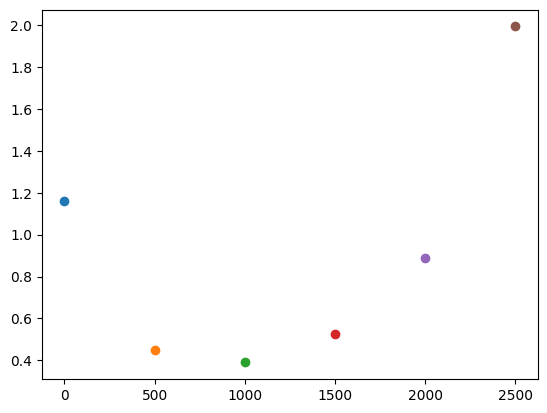

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.RAdam(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

9. RMSprop

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=2932145127424.00000, learning rate=0.1000000000
iteration 500: training loss=1.01548, validation loss=1.16730, learning rate=0.0729000000
iteration 1000: training loss=1.01480, validation loss=1.16673, learning rate=0.0430467210
iteration 1500: training loss=1.01055, validation loss=1.16309, learning rate=0.0254186583
iteration 2000: training loss=0.99611, validation loss=1.15217, learning rate=0.0150094635
iteration 2500: train

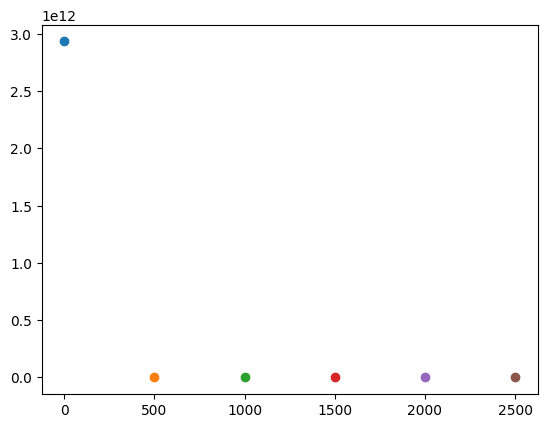

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.RMSprop(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

10. Rprop

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1975.26733, learning rate=0.1000000000
iteration 500: training loss=0.03157, validation loss=1.13949, learning rate=0.1000000000
iteration 1000: training loss=0.02423, validation loss=1.50205, learning rate=0.1000000000
iteration 1500: training loss=0.02176, validation loss=1.83286, learning rate=0.1000000000
iteration 2000: training loss=0.02020, validation loss=1.99696, learning rate=0.1000000000
iteration 2500: training loss=

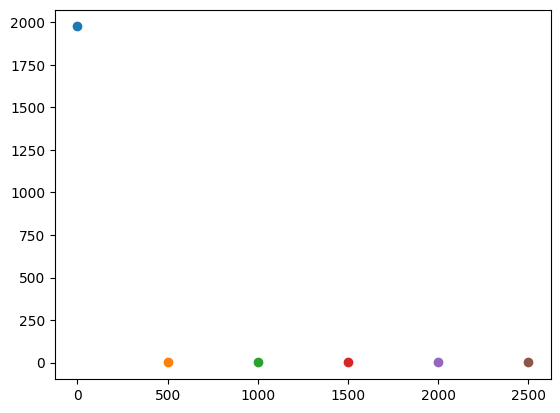

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.Rprop(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

11. SGD

RegressionModel_tunning(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=7, bias=True)
  )
)
----------------------------------------------------------------------------------------------
iteration 0: training loss=1.00827, validation loss=1.16276, learning rate=0.1000000000
iteration 500: training loss=0.49288, validation loss=0.64496, learning rate=0.0590490000
iteration 1000: training loss=0.43526, validation loss=0.61382, learning rate=0.0313810596
iteration 1500: training loss=0.40380, validation loss=0.59659, learning rate=0.0228767925
iteration 2000: training loss=0.38564, validation loss=0.58331, learning rate=0.0135085172
iteration 2500: training loss=0.3

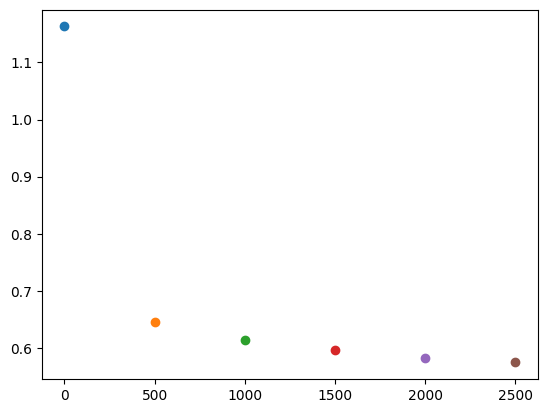

In [ ]:
best_model = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=[256, 128, 64, 32]) #assign the dimension of output layer = 7
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.SGD(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and an initial learning rate = 0.1 for training
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # decreases the learning rate by ratio 0.9 in validation phase
best_val_loss = float('inf')
MAX_iter = 3000

import matplotlib.pyplot as plt
print(best_model)
print('----------------------------------------------------------------------------------------------')
for itr in range(MAX_iter):
    optimizer.zero_grad() #start with zero gradient
    outputs = best_model(X_tf) #input the tensors into model to get the outputs
    target = Y_tf #assign the comparable target data (ground truth)
    lossvalue = Loss(outputs, target)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      scheduler.step()

    if itr %500 == 0:
        print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), scheduler.get_lr()[0]))

        plt.scatter(itr, val_loss)
        plt.plot(itr, val_loss)

**Adadelta**, **ASGD** and **SGD** are the most effective optimizers. As the curve (validation loss vs iteration) is inverse or rational. However, the **RAdam** is an ineffective optimizer as the curve is quadratic.

## **Testing on the working dataset**

Test Loss: 0.39730316400527954
-----------------------------------------------------------------------------------
[Ground_truth]
   REFUSETONSCOLLECTED  PAPERTONSCOLLECTED  MGPTONSCOLLECTED  RESORGANICSTONS  \
0            -1.522394           -1.568454         -1.087762        -0.318957   
1            -0.408823           -0.636703         -0.592916        -0.318957   
2            -0.180488           -0.362464         -0.549827        -0.318957   
3             1.089666            1.104506          0.939333        -0.318957   
4            -0.657383            0.502645          0.552057        -0.318957   

   SCHOOLORGANICTONS  LEAVESORGANICTONS  XMASTREETONS  
0          -0.394507           4.675706     -0.251010  
1          -0.394507          -0.152972     -0.251010  
2          -0.394507          -0.152972     -0.251010  
3          -0.394507          -0.152972      4.293468  
4          -0.394507          -0.122756      4.054919  
-----------------------------------------------

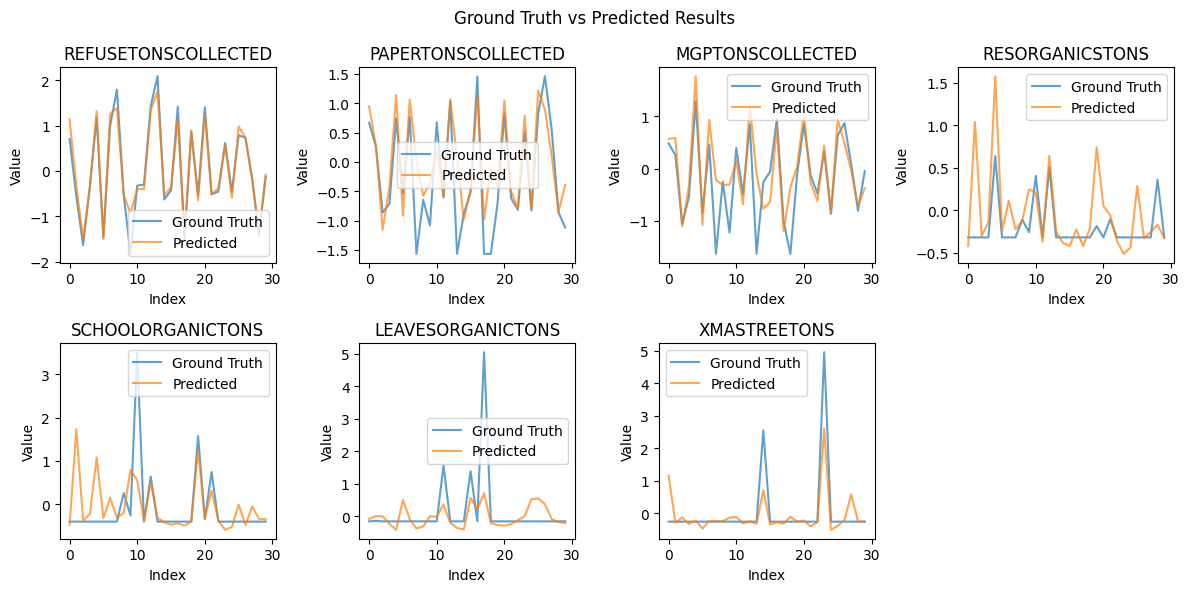

In [ ]:
#Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
#optimizer = torch.optim.SGD(best_model.parameters(), lr=0.1) #apply Stochastic Gradient Descent and a constant learning rate = 0.01 for training
#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9) #then decrease

with torch.no_grad():
    outputs = best_model(X_test_tf) #input the tensors into model to get the outputs
    test_loss = Loss(outputs, Y_test_tf) #compute the loss with ground truth(Y)
print(f"Test Loss: {test_loss.item()}")
print('-----------------------------------------------------------------------------------')

ground_truth_Y = pandas.DataFrame(Y_test_tf.numpy(), columns=['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS','SCHOOLORGANICTONS','LEAVESORGANICTONS',	'XMASTREETONS'])
print('[Ground_truth]')
print(ground_truth_Y.head())
print('-----------------------------------------------------------------------------------')
predicted_Y = pandas.DataFrame(outputs.numpy(), columns=['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS','SCHOOLORGANICTONS','LEAVESORGANICTONS',	'XMASTREETONS'])
print('[Predicted results]')
print(predicted_Y.head())

### Visualize the predicted result and ground truth
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i, column in enumerate(ground_truth_Y.columns):
    plt.subplot(2, 4, i+1)
    index_range = range(30)

    plt.plot(index_range, ground_truth_Y[column][20:50], label='Ground Truth', alpha=0.7)
    plt.plot(index_range, predicted_Y[column][20:50], label='Predicted', alpha=0.7)

    plt.title(column)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.suptitle('Ground Truth vs Predicted Results')

plt.tight_layout()
plt.show()

# **Investigate effects of mini-batch learning**

In [ ]:
###Train the model with mini-batch learning and tunned hyperparameters
from torch.utils.data import DataLoader, TensorDataset
MAX_iter = 500 + 1 ##Adjustable
batch_size= 64  ##Adjustable
hidden_layer = [256, 128, 64,32] ##Adjustable
learning_rate = 0.01 ##Adjustable
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
model2 = RegressionModel_tunning(input_size=len(X.columns),hidden_sizes=hidden_layer)  # Apply the best hidden layer dimension from the hyperparameter tunning
Loss = nn.MSELoss() #choose the loss function (Mean Squared Error)
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate) #apply Stochastic Gradient Descent and a constant learning rate = 0.01 for training
#scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) #then decrease
dataset = TensorDataset(X_tf, Y_tf)
training_loader = DataLoader(dataset, batch_size, shuffle=True)
best_val_loss = float('inf')

for itr in range(MAX_iter):
  for i, data in enumerate(training_loader): # train on each mini-batch
    inputs, labels = data
    optimizer.zero_grad() #start with zero gradient
    outputs = model2(inputs) #input the tensors into model to get the outputs
    lossvalue = Loss(outputs, labels)  #compute the loss
    lossvalue.backward()
    optimizer.step()

    ### Validation
    model2.eval()
    with torch.no_grad():
        val_outputs = model2(X_val_tf)
        val_loss = Loss(val_outputs, Y_val_tf)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      #scheduler.step()
  if itr %100 == 0:
      print("iteration {}: training loss={:.5f}, validation loss={:.5f}, learning rate={:.10f}".format(itr, lossvalue.item(), val_loss.item(), optimizer.param_groups[0]['lr']))

### **Test the trained model**
Loss = nn.L1Loss()
with torch.no_grad():
    outputs2 = model2(X_test_tf) #input the tensors into model to get the outputs
    test_loss = Loss(outputs2, Y_test_tf) #compute the loss with ground truth(Y)
print(f"Test Loss: {test_loss.item()}")

iteration 0: training loss=0.61824, validation loss=0.91523, learning rate=0.0100000000
iteration 100: training loss=0.54143, validation loss=0.44586, learning rate=0.0100000000
iteration 200: training loss=0.43963, validation loss=0.90356, learning rate=0.0100000000
iteration 300: training loss=0.12880, validation loss=1.22497, learning rate=0.0100000000
iteration 400: training loss=0.13877, validation loss=1.42966, learning rate=0.0100000000
iteration 500: training loss=0.04704, validation loss=1.53894, learning rate=0.0100000000
Test Loss: 0.85968017578125


### **Choose a year for visualization**

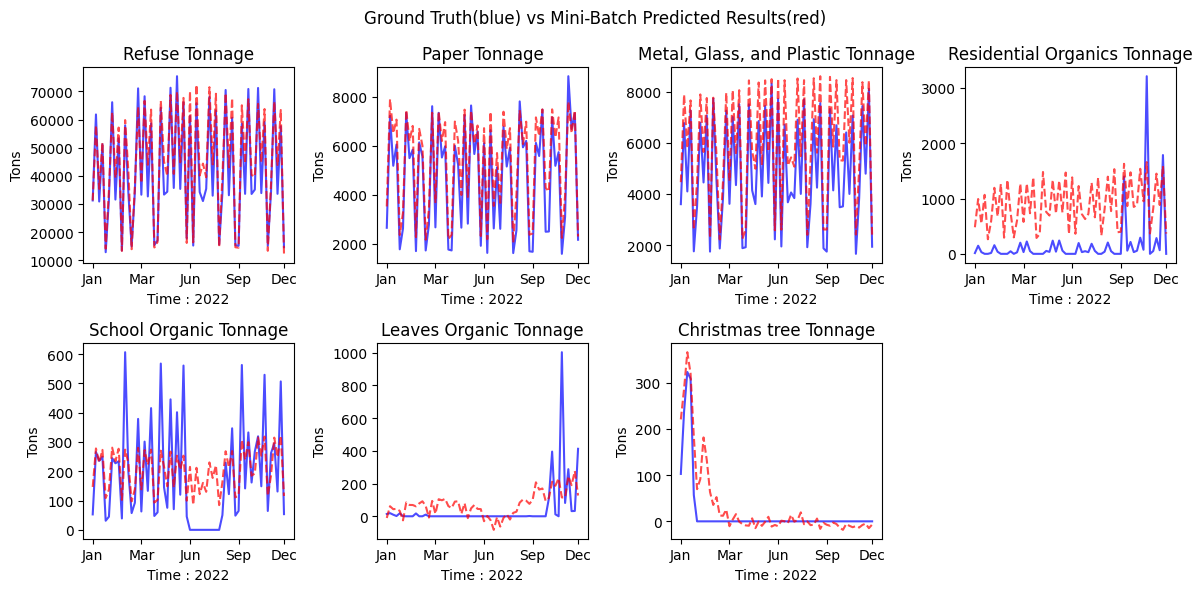

In [ ]:
#choosen_borough = 'Borough (Manhattan)' #Bronx / Brooklyn / Manhattan / Queens / Staten Island
choosen_year = 2022  ##Adjustable

X_test_feature = pandas.DataFrame(X_test_tf.numpy(), columns=X.columns)
X_test_feature[columns_of_feature] = pandas.DataFrame(scaler_X.inverse_transform(X_test_feature[columns_of_feature]))
#X_test_feature = X_test_feature[X_test_feature[choosen_borough] == 1]
#choosen_indices = X_test_feature[X_test_feature[choosen_borough] == 1].index

ground_truth_Y = pandas.DataFrame(Y_test_tf.numpy(), columns=['Refuse Tonnage', 'Paper Tonnage', 'Metal, Glass, and Plastic Tonnage', 'Residential Organics Tonnage', 'School Organic Tonnage', 'Leaves Organic Tonnage', 'Christmas tree Tonnage'])
ground_truth_Y = pandas.DataFrame(scaler_Y.inverse_transform(ground_truth_Y),columns=ground_truth_Y.columns)
#ground_truth_Y =ground_truth_Y.loc[choosen_indices]

predicted_Y = pandas.DataFrame(outputs2.numpy(), columns=['Refuse Tonnage', 'Paper Tonnage', 'Metal, Glass, and Plastic Tonnage', 'Residential Organics Tonnage', 'School Organic Tonnage', 'Leaves Organic Tonnage', 'Christmas tree Tonnage'])
predicted_Y = pandas.DataFrame(scaler_Y.inverse_transform(predicted_Y),columns=predicted_Y.columns)
#predicted_Y =predicted_Y.loc[choosen_indices]


### Visualize the predicted result and ground truth
X_vis = X_test_feature[X_test_feature['Year'] == choosen_year].reset_index(drop=True)
choosen_idx = X_test_feature[X_test_feature['Year'] == choosen_year].index
ground_truth_Y_vis =ground_truth_Y.loc[choosen_idx].reset_index(drop=True)
predicted_Y_vis =predicted_Y.loc[choosen_idx].reset_index(drop=True)

###Numerical results
"""
print('[Input features]')
print(X_vis.head())
print('-----------------------------------------------------------------------------------')
print('[Ground_truth]')
print(ground_truth_Y_vis.head())
print('-----------------------------------------------------------------------------------')
print('[Predicted results]')
print(predicted_Y_vis.head())
print('-----------------------------------------------------------------------------------')
"""
###Plot the data samples
plt.figure(figsize=(12, 6))
for i, column in enumerate(ground_truth_Y_vis.columns):
    plt.subplot(2, 4, i+1)
    custom_x_ticks = [0, 15, 30, 45, 59]
    custom_x_labels = ['Jan', 'Mar', 'Jun', 'Sep', 'Dec']

    plt.plot(X_vis.index, ground_truth_Y_vis[column][:], label='Ground Truth', alpha=0.7,color='blue')
    plt.plot(X_vis.index, predicted_Y_vis[column][:], label='Predicted', alpha=0.7,color='red',linestyle='--')

    plt.title(column)
    time = str(choosen_year)
    plt.xlabel('Time : ' + time)
    plt.ylabel('Tons')
    plt.xticks(custom_x_ticks)
    plt.gca().set_xticklabels(custom_x_labels)
    #plt.xticks(index_range)
    #plt.legend()

plt.suptitle('Ground Truth(blue) vs Mini-Batch Predicted Results(red)')

plt.tight_layout()
plt.show()

The loss on the testing data set for the mini-batch trained weights is about a third of the batch trained weights. The plots also reflect an improment in prediction. This is seen with the negative values on the paper and mgp data. Less oscilation is also observed on the  leave and xmas data plots near the zero values.